# Taller 2
## Daniel Leyva Castro

In [1]:
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np
from copy import deepcopy
import networkx as nx

## Funciones y clases Auxiliares

In [ ]:
# helper functions
def crossProduct(p0, p1, p2):
    x0, y0 = p0
    x1, y1 = p1
    x2, y2 = p2
    return (x1-x0)*(y2-y0) - (x2-x0)*(y1-y0)


def rotation(p0, p1, p2):
    cp = crossProduct(p0, p1, p2)
    if cp > 0:
        return 'l' # left
    elif cp == 0:
        return None # collinear
    else:
        return 'r' # right

class Node:
    def __init__(self, data):
        self.data = data
        self.left = None
        self.right = None


def insertBST(root, node, y):
    #print(f"node: {node.data.label} intersect: {node.data.sp_intersection_point(y)}")
    #print(f"root: {root.data.label} intersect: {root.data.sp_intersection_point(y)}")

    if (node.data.sp_intersection_point(y) < root.data.sp_intersection_point(y)):
        if root.left is None:
            root.left = node
        else:
            insertBST(root.left, node, y)
    else:
        if root.right is None:
            root.right = node
        else:
            insertBST(root.right, node, y)


def inOrder(node):
    inorderArr = []

    if node.left is not None:
        leftInorderArr = inOrder(node.left)
        inorderArr.extend(leftInorderArr)

    inorderArr.append(node.data)

    if node.right is not None:
        rightInorderArr = inOrder(node.right)
        inorderArr.extend(rightInorderArr)
    return inorderArr


## Vertices, Arista, Semiaristas y Caras


In [11]:
# vertex plot utilitie
types = {
    'unknown': ('o', "unknown"),
    'o': ('sg', 'Origin'),
    'e': ('sr', 'End'),
    's': ('^k', 'Split'),
    'm': ('vy', 'Merge'),
    'r': ('ob', 'Regular'),
#    'h': '*m'
}

# Main clases
class Vertex:
    def __init__(self, label = None, x=None, y=None, incident = []):
        self.label = label
        self.x = x
        self.y = y
        self.coords = (x,y)
        self.incident = incident
        self.vtype = 'unknown'

    def toTuple(self):
        return self.coords

    def __lt__(self, p):
        return (self.y > p.y) or (self.y == p.y and self.x < p.x)

    def __repr__(self):
        return f"V(L:{self.label} C:({self.x},{self.y}) I:{[i.label for i in self.incident]})"

    def __str__(self):
        return f"V(L:{self.label} C:({self.x},{self.y}) I:{[i.label for i in self.incident]})"

    def add2plot(self):
        plt.plot(self.x, self.y, types[self.vtype][0], label=types[self.vtype][1])


class Edge:
    def __init__(self, start, end):
        self.start = start
        self.end = end

    def __repr__(self):
        return f"E({self.start.coords} -> {self.end.coords})"

    def __srt__(self):
        return f"E({self.start.coords} -> {self.end.coords})"

    def add2plot(self):
        #with no label
        plt.plot([self.start.x, self.end.x], [self.start.y, self.end.y], '-k', label='_nolegend_')

class SemiEdge:
    def __init__(self, label=None, start=None, prev=None, next=None, twin=None, face=None):
        self.label = label
        self.start = start
        self.prev = prev
        self.next = next
        self.twin = twin
        self.face = face
        self.helper = None

    def sp_intersection_point(self, y):
        alpha = (y - self.next.start_point.y) / (self.start.y - self.next.start_point.y)
        x = alpha * self.start.x + (1 - alpha) * self.next.start_point.x
        return x

    def add2plot(self):
        plt.plot([self.start.x, self.next.start.x], [self.start.y, self.next.start.y], '-k')

    def __repr__(self):
        return f'{self.label}({self.start.coords}, {self.next.start.coords})' if self.next else f'{self.label}({self.start.coords})'

    def __str__(self):
        return f'{self.label}({self.start.coords}, {self.next.start.coords})' if self.next else f'{self.label}({self.start.coords})'



class Face:
    def __init__(self, extF=None, intF=None, label=None):
        if intF is None:
            intF = []
        if extF is None:
            extF = []
        self.extF = extF
        self.intF = intF
        self.label = label

    def __repr__(self):
        return f"------------\nF(L:{self.label}\nextF:{self.extF}\nintF:{self.intF}\n------------)"

    def add2plot(self):
        #plot filled face
        plt.fill([i.start.x for i in self.extF], [i.start.y for i in self.extF], 'b', alpha=0.2)



## Clase Principal

In [18]:
# Main class
class LDCE:
    def __init__(self, points):

        self.vertices = []
        self.semiEdges = None
        self.faces = []

        self.points = points
        self.edges = None
        self.build()
        self.assingNodesTypes()

    # def plotOriginal(self):
    #     # print(self.points)
    #     plt.fill(*zip(*self.points), 'b', alpha=0.5)
    #     plt.plot()

    def plotPolygon(self):
        self.plotEdges()
        self.plotVertices()

    def plotEdges(self):
        for e in self.edges:
            e.add2plot()

    def plotVertices(self):
        points = {}
        for p in self.vertices:
            if types[p.vtype] not in points:
                points[types[p.vtype]] = [p.coords]
            else:
                points[types[p.vtype]].append(p.coords)
        pprint.pprint(points)
        for i in points:
            plt.plot(*zip(*points[i]), i[0], label=i[1])



    def vertices2Df(self):
        vtypes = [types[i.vtype][1] for i in self.vertices]
        coords = [i.coords for i in self.vertices]
        labels = [i.label for i in self.vertices]
        incident = [i.incident for i in self.vertices]

        df = {
            'Vertex': labels,
            'Type': vtypes,
            'Coords': coords,
            'Incident': incident
        }
        return pd.DataFrame(data = df)

    def semiEdges2Df(self):
        print(type(self.semiEdges))
        labels = [se.label for se in self.semiEdges]
        start_points = [se.start.label for se in self.semiEdges]
        end_points = [se.next.start.label for se in self.semiEdges]
        prevs = [se.prev.label for se in self.semiEdges]
        nexts = [se.next.label for se in self.semiEdges]
        twins = [se.twin.label for se in self.semiEdges]
        faces = [se.face.label if se.face is not None else None for se in self.semiEdges]

        df = {'SemiEdge': labels, 'Start Points': start_points, 'End Points': end_points, 'Prev': prevs, 'Nexts': nexts,
             'Twin': twins, 'Face': faces}
        #d = {'SemiEdge': labels, 'Start Points': start_points, 'End Points': end_points, 'Prev': prevs, 'Nexts': nexts, 'Twin': twins}
        return pd.DataFrame(data = df)


    def faces2Df(self):
        inF = [[s.label for s in f.intF] if f.intF else None for f in self.faces]
        exF = [[s.label for s in f.extF] if f.extF else None for f in self.faces]
        labels = [f.label for f in self.faces]
        df = {
            'Face': labels,
            'Internal': inF,
            'External': exF
        }
        return pd.DataFrame(data = df)

    def build(self):
        self.semiEdges = [[],[]]
        # Building Vertices
        self.vertices = [Vertex(f'{self.points.index(i)}', *i) for i in self.points]
        # Building Edges
        edges = [Edge(self.vertices[i], self.vertices[(i+1)%len(self.vertices)]) for i in range(len(self.vertices))]

        # Building SemiEdges
        for i in range(len(edges)):
            ns = SemiEdge(start=edges[i].start, label=f'S{i},1')
            nt = SemiEdge(start=edges[i].end, label=f'S{i},2')
            ns.twin = nt
            nt.twin = ns
            self.semiEdges[0].append(ns)
            self.semiEdges[1].append(nt)
        self.semiEdges[1].reverse()

        # build the doubly linked list
        for i in range(len(self.semiEdges[0])-1):
            self.semiEdges[0][i].next = self.semiEdges[0][(i+1)]
            self.semiEdges[0][i].prev = self.semiEdges[0][(i-1)]
            self.semiEdges[1][i].next = self.semiEdges[1][(i+1)]
            self.semiEdges[1][i].prev = self.semiEdges[1][(i-1)]

        self.semiEdges[0][-1].next = self.semiEdges[0][0]
        self.semiEdges[0][-1].prev = self.semiEdges[0][-2]
        self.semiEdges[1][-1].next = self.semiEdges[1][0]
        self.semiEdges[1][-1].prev = self.semiEdges[1][-2]

        for i in range(len(self.vertices)):
            self.vertices[i].incident = [self.semiEdges[0][i], self.semiEdges[0][i].twin.next]

        next = self.semiEdges[0][1]
        v0 = self.semiEdges[0][0].start
        count = 0
        front1 = [self.semiEdges[0][0]]

        while next.start != v0:
            if count > len(self.semiEdges[0]):
                print('Error')
                break
            count += 1
            front1.append(next)
            next = next.next

        next = self.semiEdges[1][1]
        v0 = self.semiEdges[1][0].start
        count = 0
        front2 = [self.semiEdges[1][0]]

        while next.start != v0:
            if count > len(self.semiEdges[1]):
                print('Error')
                break
            count += 1
            front2.append(next)
            next = next.next

        f1 = Face(extF=None, intF=front1, label='F1')
        f2 = Face(extF=front1, intF=None, label='F2')

        self.faces.append(f1)
        self.faces.append(f2)
        self.semiEdges = self.semiEdges[0] + self.semiEdges[1]
        self.edges = edges

    def assingNodesTypes(self):
        for se in self.faces[0].intF:
            prev_p = se.prev.start.coords
            curr_p = se.start.coords
            next_p = se.next.start.coords

            if (se.start.y >= se.prev.start.y and se.start.y > se.next.start.y) or (se.start.y > se.prev.start.y and se.start.y >= se.next.start.y):
                if rotation(prev_p, curr_p, next_p) == 'l':
                    se.start.vtype = 's'
                else:
                    se.start.vtype = 'o'
            elif (se.start.y <= se.prev.start.y and se.start.y < se.next.start.y) or (se.start.y < se.prev.start.y and se.start.y <= se.next.start.y):
                if rotation(prev_p, curr_p, next_p) == 'l':
                    se.start.vtype = 'm'
                else:
                    se.start.vtype = 'e'

            else:
                se.start.vtype = 'r'


## Creacioón del objeto

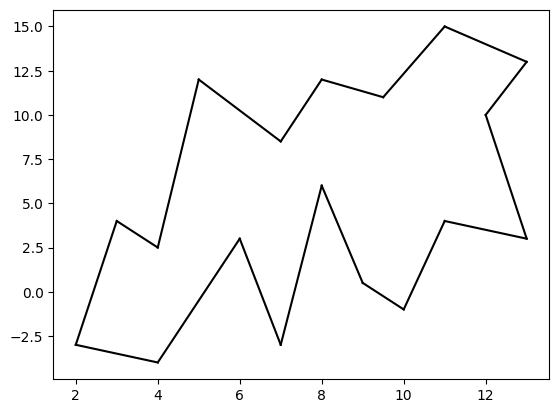

In [4]:
N = [(9, 0.5), (8, 6), (7, -3), (6, 3), (4, -4), (2, -3), (3, 4), (4, 2.5), (5, 12), (7, 8.5), (8, 12), (9.5, 11),
     (11, 15), (13, 13), (12, 10), (13, 3), (11, 4), (10, -1)]


ldce = LDCE(N)
ldce.plotEdges()

## Punto 1 Lista de aristas doblemente enlazadas

La funcion `Build()` se encarga de crear la lista de aristas doblemente enlazadas, para esto se crean los vertices, aristas y semi aristas, luego se enlazan las semi aristas para formar la lista doblemente enlazada, luego se enlazan las semi aristas con los vertices para formar la lista de aristas incidentes en cada vertice, y por ultimo se crean las caras y se enlazan las semi aristas con las caras para formar la lista de semi aristas incidentes en cada cara.
### Vertices

In [5]:
df = ldce.vertices2Df()
display(df)

,Vertex,Type,Coords,Incident
0,0,Regular,"(9, 0.5)","[S0,1((9, 0.5), (8, 6)), S17,2((9, 0.5), (10, ..."
1,1,Split,"(8, 6)","[S1,1((8, 6), (7, -3)), S0,2((8, 6), (9, 0.5))]"
2,2,End,"(7, -3)","[S2,1((7, -3), (6, 3)), S1,2((7, -3), (8, 6))]"
3,3,Split,"(6, 3)","[S3,1((6, 3), (4, -4)), S2,2((6, 3), (7, -3))]"
4,4,End,"(4, -4)","[S4,1((4, -4), (2, -3)), S3,2((4, -4), (6, 3))]"
5,5,Regular,"(2, -3)","[S5,1((2, -3), (3, 4)), S4,2((2, -3), (4, -4))]"
6,6,Origin,"(3, 4)","[S6,1((3, 4), (4, 2.5)), S5,2((3, 4), (2, -3))]"
7,7,Merge,"(4, 2.5)","[S7,1((4, 2.5), (5, 12)), S6,2((4, 2.5), (3, 4))]"
8,8,Origin,"(5, 12)","[S8,1((5, 12), (7, 8.5)), S7,2((5, 12), (4, 2...."
9,9,Merge,"(7, 8.5)","[S9,1((7, 8.5), (8, 12)), S8,2((7, 8.5), (5, 1..."


### SemiEdges

In [6]:
df = ldce.semiEdges2Df()
display(df)

<class 'list'>


,SemiEdge,Start Points,End Points,Prev,Nexts,Twin,Face
0,"S0,1",0,1,"S17,1","S1,1","S0,2",None
1,"S1,1",1,2,"S0,1","S2,1","S1,2",None
2,"S2,1",2,3,"S1,1","S3,1","S2,2",None
3,"S3,1",3,4,"S2,1","S4,1","S3,2",None
4,"S4,1",4,5,"S3,1","S5,1","S4,2",None
5,"S5,1",5,6,"S4,1","S6,1","S5,2",None
6,"S6,1",6,7,"S5,1","S7,1","S6,2",None
7,"S7,1",7,8,"S6,1","S8,1","S7,2",None
8,"S8,1",8,9,"S7,1","S9,1","S8,2",None
9,"S9,1",9,10,"S8,1","S10,1","S9,2",None


### Faces

In [7]:
df = ldce.faces2Df()
display(df)

,Face,Internal,External
0,F1,"[S0,1, S1,1, S2,1, S3,1, S4,1, S5,1, S6,1, S7,...",None
1,F2,None,"[S0,1, S1,1, S2,1, S3,1, S4,1, S5,1, S6,1, S7,..."


## Punto 2 Convertir en Ymonotono
### Identificar tipo de vertice.
La funcion `assingNodesTypes()` se encarga de asignar los tipos de nodos a cada vertice, para esto se recorre la lista de semi aristas incidentes en la cara 1, se obtienen los puntos previos, actuales y siguientes, luego se calcula la rotacion de los puntos, y se asigna el tipo de nodo segun la rotacion y la posicion del punto actual y sus vecinos.

{('^k', 'Split'): [(8, 6), (6, 3), (11, 4)],
 ('ob', 'Regular'): [(9, 0.5), (2, -3), (13, 13), (12, 10)],
 ('sg', 'Origin'): [(3, 4), (5, 12), (8, 12), (11, 15)],
 ('sr', 'End'): [(7, -3), (4, -4), (13, 3), (10, -1)],
 ('vy', 'Merge'): [(4, 2.5), (7, 8.5), (9.5, 11)]}


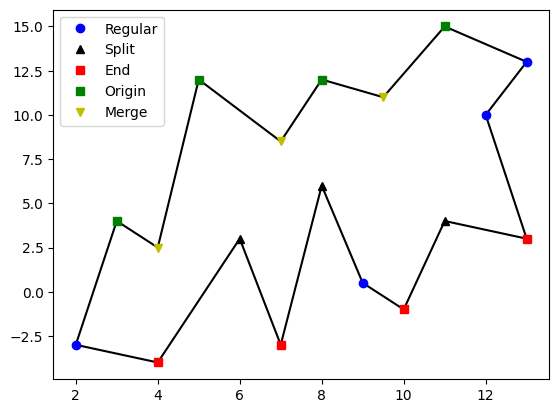

In [19]:
ldce.plotPolygon()
plt.legend()
plt.show()
